In [2]:
%matplotlib inline

In [3]:
%config InlineBackend.figure_format = 'retina'

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import starry
import warnings
from scipy.special import legendre
from scipy.integrate import quad


warnings.filterwarnings("ignore")
starry.config.lazy = False
starry.config.quiet = True

/opt/anaconda3/envs/starry-env/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/anaconda3/envs/starry-env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


To derive this formula, we can start with the formula for $x_{sphere}$ in terms of $\rho$, $\theta$, and $\phi$:

$$x_{sphere} = \rho \sin{\phi} \cos{\theta}$$

Substituting the expressions for $\rho$, $\theta$, and $\phi$ in terms of the Cartesian coordinates $(x,y)$, we get:

\begin{align*}
x_{sphere} &= \sqrt{x^2 + y^2} \sin{\arccos{\frac{z}{\sqrt{x^2 + y^2}}}} \cos{\arctan{\frac{y}{x}}} \
&= \sin{x} \sqrt{x^2 + y^2} \cdot \frac{x}{\sqrt{x^2 + y^2}} \
&= \sin{x} \cdot \frac{x}{\sqrt{1 + \tan^2{\theta}}} \
&= \sin{x} \cdot \sqrt{\frac{1 - z^2}{1 + \tan^2{\theta}}}
\end{align*}

Where the last step follows from the relationship $z = \rho \cos{\phi} = \sqrt{x^2 + y^2} \cos{\phi}$.

In [5]:
def phi(y, r=np.inf):
    return np.arcsin(y) + 2 * (1 - np.sqrt(1 - y ** 2)) / (y * r)

def transform(x, y, rs=np.inf):
    # Radial coordinate on disk
    rho = np.sqrt(x ** 2 + y ** 2)
    
    # Angular coordinate on disk (conserved)
    t = np.arctan2(y, x)

    # z coordinate on sphere
    z_ = np.cos(phi(rho, rs))

    # Compute x and y from conserved angle
    x_ = np.sign(x) * np.sqrt((1 - z_ ** 2) / (1 + np.tan(t) ** 2))
    y_ = np.sign(y) * np.sqrt(1 - x_ ** 2 - z_ ** 2)

    # Conver to lat-lon
    lat = np.arcsin(y_)
    lon = np.arctan2(x_, z_)
    return lat * 180 / np.pi, lon * 180 / np.pi

def show(map, nx=300, ax=None, rs=np.inf):
    x, y = np.linspace(-1, 1, nx), np.linspace(-1, 1, nx)
    x, y = np.meshgrid(x, y)
    x = x.flatten()
    y = y.flatten()
    lat, lon = transform(x, y, rs=rs)
    I = map.intensity(lat=lat , lon=lon).reshape(nx, nx)
    if ax is None:
        fig, ax = plt.subplots(1, figsize=(5, 5))
        ax.set_aspect(1)
        ax.axis("off")
    ax.imshow(I, origin="lower")
    

def show_ylms(lmax=5, **kwargs):
    # Set up the plot
    fig, ax = plt.subplots(lmax + 1, 2 * lmax + 1, figsize=(9, 6))
    fig.subplots_adjust(hspace=0)
    for axis in ax.flatten():
        axis.set_xticks([])
        axis.set_yticks([])
        axis.spines["top"].set_visible(False)
        axis.spines["right"].set_visible(False)
        axis.spines["bottom"].set_visible(False)
        axis.spines["left"].set_visible(False)
    for l in range(lmax + 1):
        ax[l, lmax - l].set_ylabel(
            r"$l = %d$" % l,
            rotation="horizontal",
            labelpad=15,
            y=0.35,
            fontsize=11,
            alpha=0.5,
        )
    for j, m in enumerate(range(-lmax, lmax + 1)):
        if m < 0:
            ax[-1, j].set_xlabel(
                r"$m {=} $-$%d$" % -m,
                labelpad=5,
                fontsize=11,
                rotation=45,
                x=0.3,
                alpha=0.5,
            )
        else:
            ax[-1, j].set_xlabel(
                r"$m = %d$" % m,
                labelpad=5,
                fontsize=11,
                rotation=45,
                x=0.35,
                alpha=0.5,
            )

    # Loop over the orders and degrees
    map = starry.Map(lmax)
    for i, l in enumerate(range(lmax + 1)):
        for j, m in enumerate(range(-l, l + 1)):

            # Offset the index for centered plotting
            j += lmax - l

            # Compute the spherical harmonic
            map.reset()
            if l > 0:
                map[l, m] = 1.0
            show(map, ax=ax[i, j], **kwargs)
            ax[i, j].axis("on")
            ax[i, j].set_rasterization_zorder(1)

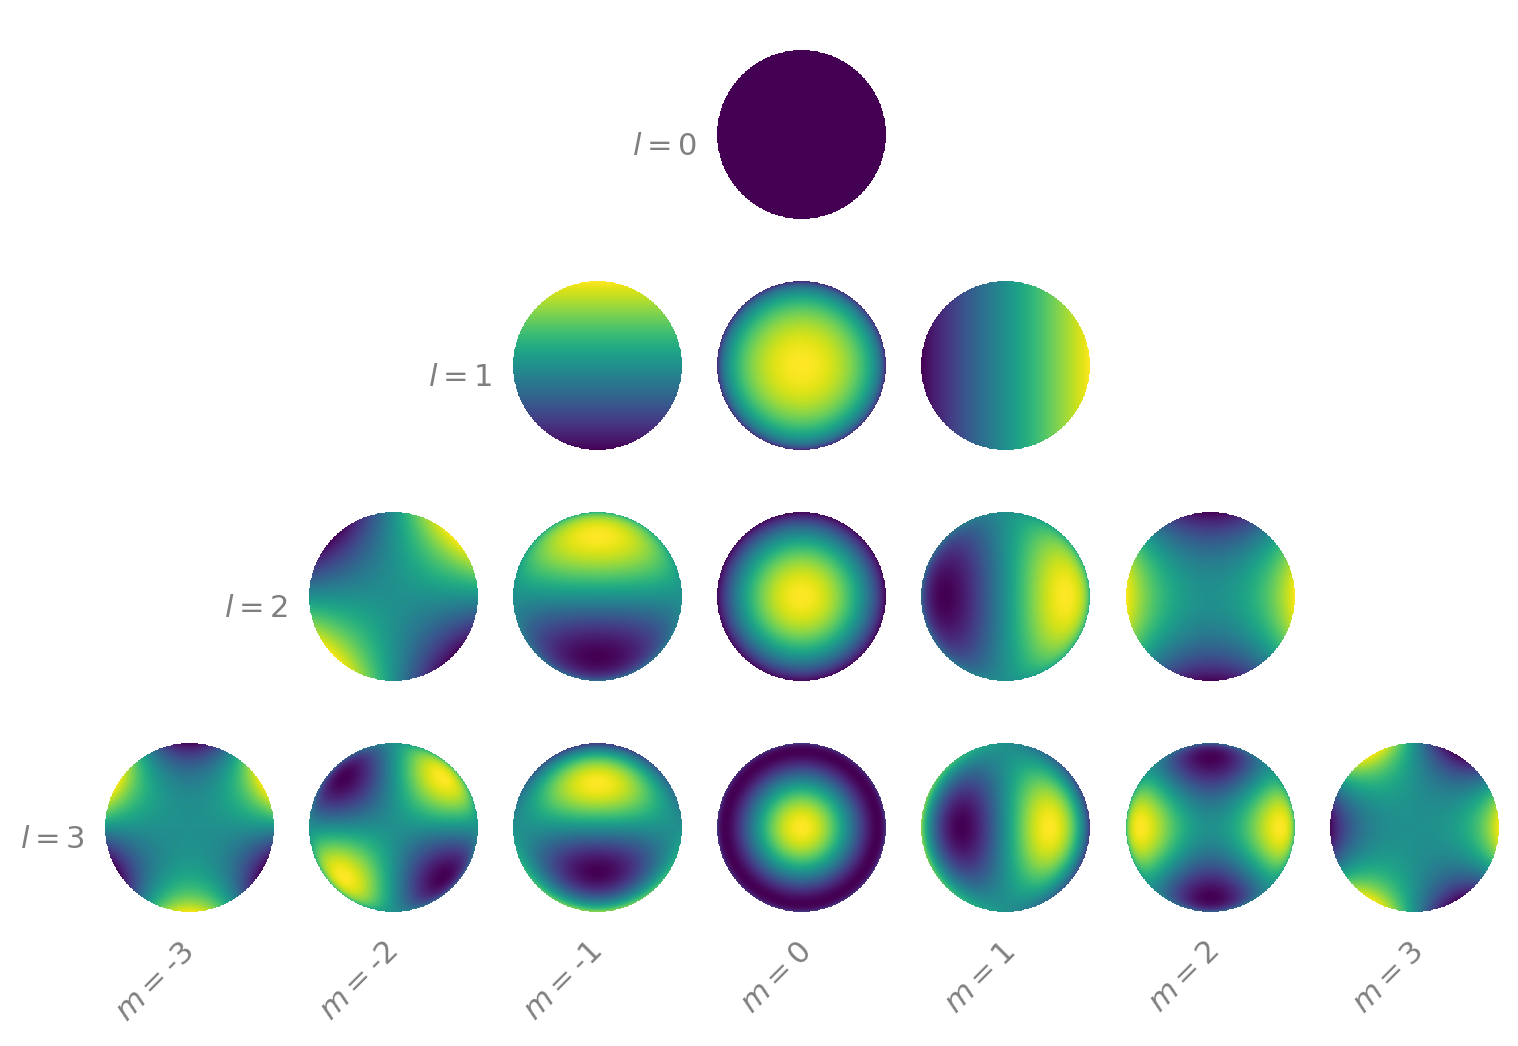

In [6]:
show_ylms(lmax=3, rs=np.inf)

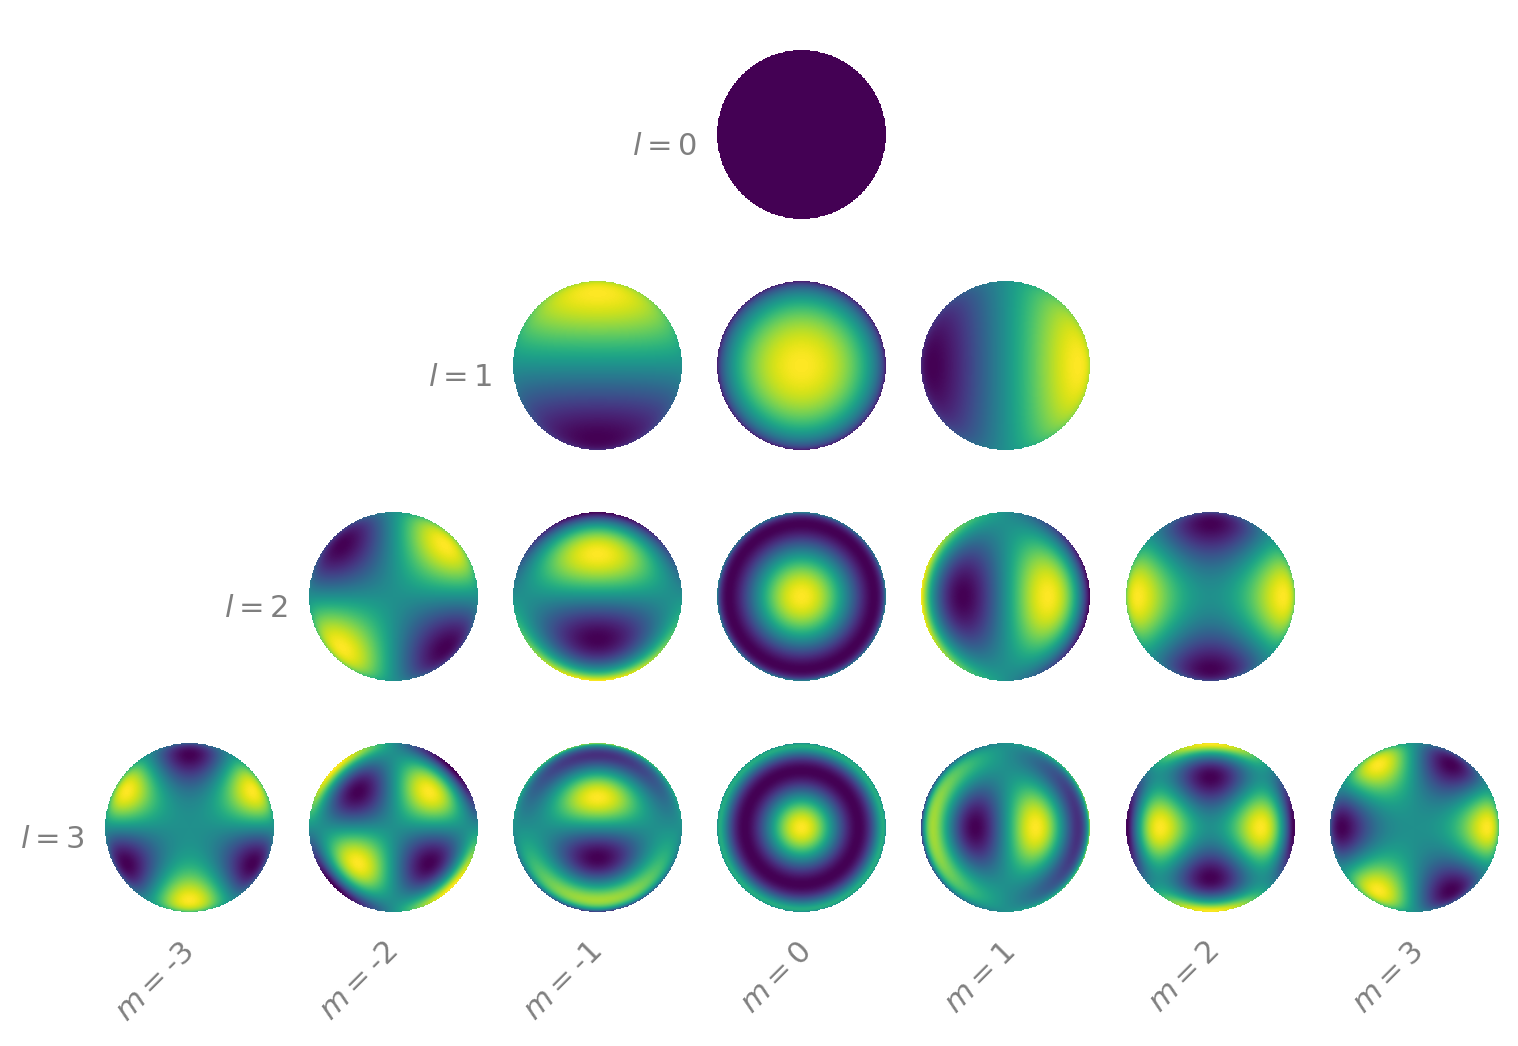

In [7]:
show_ylms(lmax=3, rs=2)

In [34]:
def energy(r, l, theta, rs, vrot):
    """
    the relation between the energy observed at 
    infinite distance and the emitted energy at the surface
    """
    y = r * np.sin(theta)
    e = 1 - y * vrot * np.sin(theta) + (y**2 - 1/2) * vrot**2 * np.sin(theta)**2 - 1/rs * (1 - (y**2 - 1/2) * vrot**2 * np.sin(theta)**2)
    return e


The energy factor we're interested in here is: 
$$e/e_{surf} = 1 - yv_{rot}\sin{\theta_0} + (y^2 - 1/2)v_{rot}^2\sin{\theta_0^2} - \frac{1}{r_s}(1-(y^2 - 1/2)v_{rot}^2\sin{\theta_0}^2)$$

In [35]:
def intensity(r, l, theta, rs, vrot):
    """
    Radial intensity of the zonal spherical harmonic of degree `l`
    projected onto the unit disk for a neutron star of radius `rs`
    in units of the Schwarzschild radius.
    """
    t = 2 * (1 - np.sqrt(1 - r**2)) / (r * rs)
    coslat = np.sqrt(1 - r**2) * np.cos(t) - r * np.sin(t)
    return np.sqrt(2 * l + 1) / np.pi * legendre(l)(coslat) * energy(r,l,np.arccos(coslat),rs, vrot)

The intensity of the spherical harmonic $Y_{l,0}$ projected onto the disk is

$$
F_l = 2\sqrt{2l + 1}\int_0^1 P_l\left( \sqrt{1 - r^2} \cos \theta(r) - r \sin \theta(r) \right) r dr
$$

where

$$
\theta(r) = 2 \frac{1 - \sqrt{1 - r^2}}{r r_s}
$$

The integral in this formula is an integral over the radial coordinate $r$. The angle $\theta(r)$ is the angle between the radius vector and the normal to the unit disk at a given point on the surface of the neutron star.

To find the radial intensity of the zonal spherical harmonic, we need to take the derivative of the intensity $F_l$ with respect to the radial coordinate $r$. This will give you the radial component of the intensity.

The gravitational field created by a mass $M$ at a distance $r$ from the center of the neutron star is given by:

$$
\mathbf{g} = -\frac{GM}{r^2} \mathbf{\hat{r}}
$$

where $G$ is the gravitational constant and $\mathbf{\hat{r}}$ is the unit vector in the direction of the radius vector $\mathbf{r}$.

The gravitational field created by the mass $M$ can be "mirrored" across the surface of the neutron star by placing a virtual mass $-M$ at a distance $r_s$ from the center of the neutron star, where $r_s$ is the Schwarzschild radius of the neutron star. The resulting gravitational field is then given by:

$$
\mathbf{g}' = -\frac{GM}{r^2} \mathbf{\hat{r}} + \frac{GM}{r_s^2} \mathbf{\hat{r}'}
$$

where $\mathbf{\hat{r}'}$ is the unit vector in the direction of the radius vector $\mathbf{r}'$, which points from the center of the neutron star to the virtual mass.

Expanding in spherical harmonics:

$$
\mathbf{g}' = \sum_{l=0}^{\infty} \sum_{m=-l}^{l} g_{lm}(r) Y_{lm}(\theta,\phi)
$$

where $Y_{lm}(\theta,\phi)$ are the spherical harmonics, and $g_{lm}(r)$ are the expansion coefficients. The intensity of the zonal spherical harmonic $F_l$ is then given by:

$$
F_l = \int_{S} \mathbf{g}' \cdot \mathbf{Y}_{l0}^* dS
$$

where $S$ is the surface of the neutron star, and $\mathbf{Y}{l0}^*$ is the complex conjugate of the spherical harmonic $\mathbf{Y}{l0}$.

$$
\int_{S} Y_{lm}^*(\theta,\phi) Y_{l'm'}(\theta,\phi) dS = \delta_{ll'} \delta_{mm'}
$$

Substituting this identity into the expression for the intensity $F_l$ and using the orthonormality of the spherical harmonics, we get:

$$
F_l = \int_{S} \mathbf{g}' \cdot \mathbf{Y}{l0}^* dS = \int{S} \sum_{l=0}^{\infty} \sum_{m=-l}^{l} g_{lm}(r) Y_{lm}^*(\theta,\phi) Y_{l0}(\theta,\phi) dS = g_{l0}(r)
$$

where we have used the fact that the Kronecker delta is zero unless $l = l'$ and $m = m'$.

Therefore, the intensity of the zonal spherical harmonic $F_l$ is given by the expansion coefficient $g_{l0}(r)$ of the gravitational field $\mathbf{g}'$.

The expansion coefficient $g_{l0}(r)$ can be computed using the following formula:

$$
g_{l0}(r) = 2\sqrt{2l + 1}\int_0^1 P_l\left( \sqrt{1 - r^2} \cos \theta(r) - r \sin \theta(r) \right) r dr
$$

$$
F_l = 2\sqrt{2l + 1}\int_0^1 P_l\left( \sqrt{1 - r^2} \cos \theta(r) - r \sin \theta(r) \right) r dr
$$

In [51]:
def ylm_integrals(lmax, theta, rs,vrot):
    """
    Projected intensity integrated over the unit disk.
    This is the flux one would measure from each basis component.
    """
    I = np.zeros((lmax + 1) ** 2)
    for l in range(lmax + 1):
        n = l ** 2 + l
        I[n] = 2 * np.pi * quad(lambda r: r * intensity(r, l, theta=theta,rs=rs,vrot=vrot), 0, 1)[0]
    return I

In [52]:
def design_matrix(theta, rs, vrot, lmax=30, inc=90):
    map = starry.Map(lmax)
    rT = ylm_integrals(lmax, theta, rs=rs, vrot=vrot).reshape(1, -1)
    return map.ops.right_project(
        rT,
        np.array(inc * np.pi / 180),
        np.array(0.0),
        np.atleast_1d(theta) * np.pi / 180,
    )

In [53]:
def flux(theta, y, **kwargs):
    A = design_matrix(theta, **kwargs)
    return A @ y

In [49]:
theta = np.linspace(0, 360, 100)

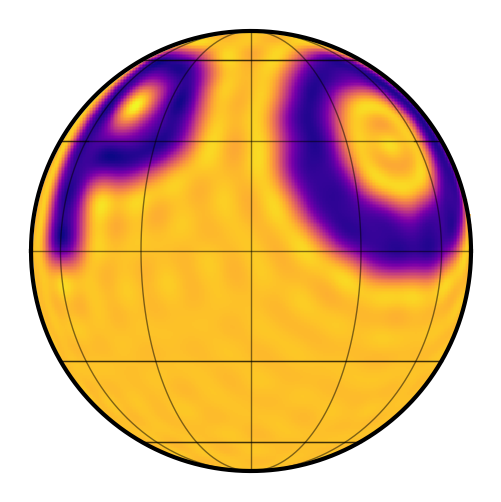

In [25]:
map = starry.Map(30)
map.load("spot")
map.amp = 1
map.show()

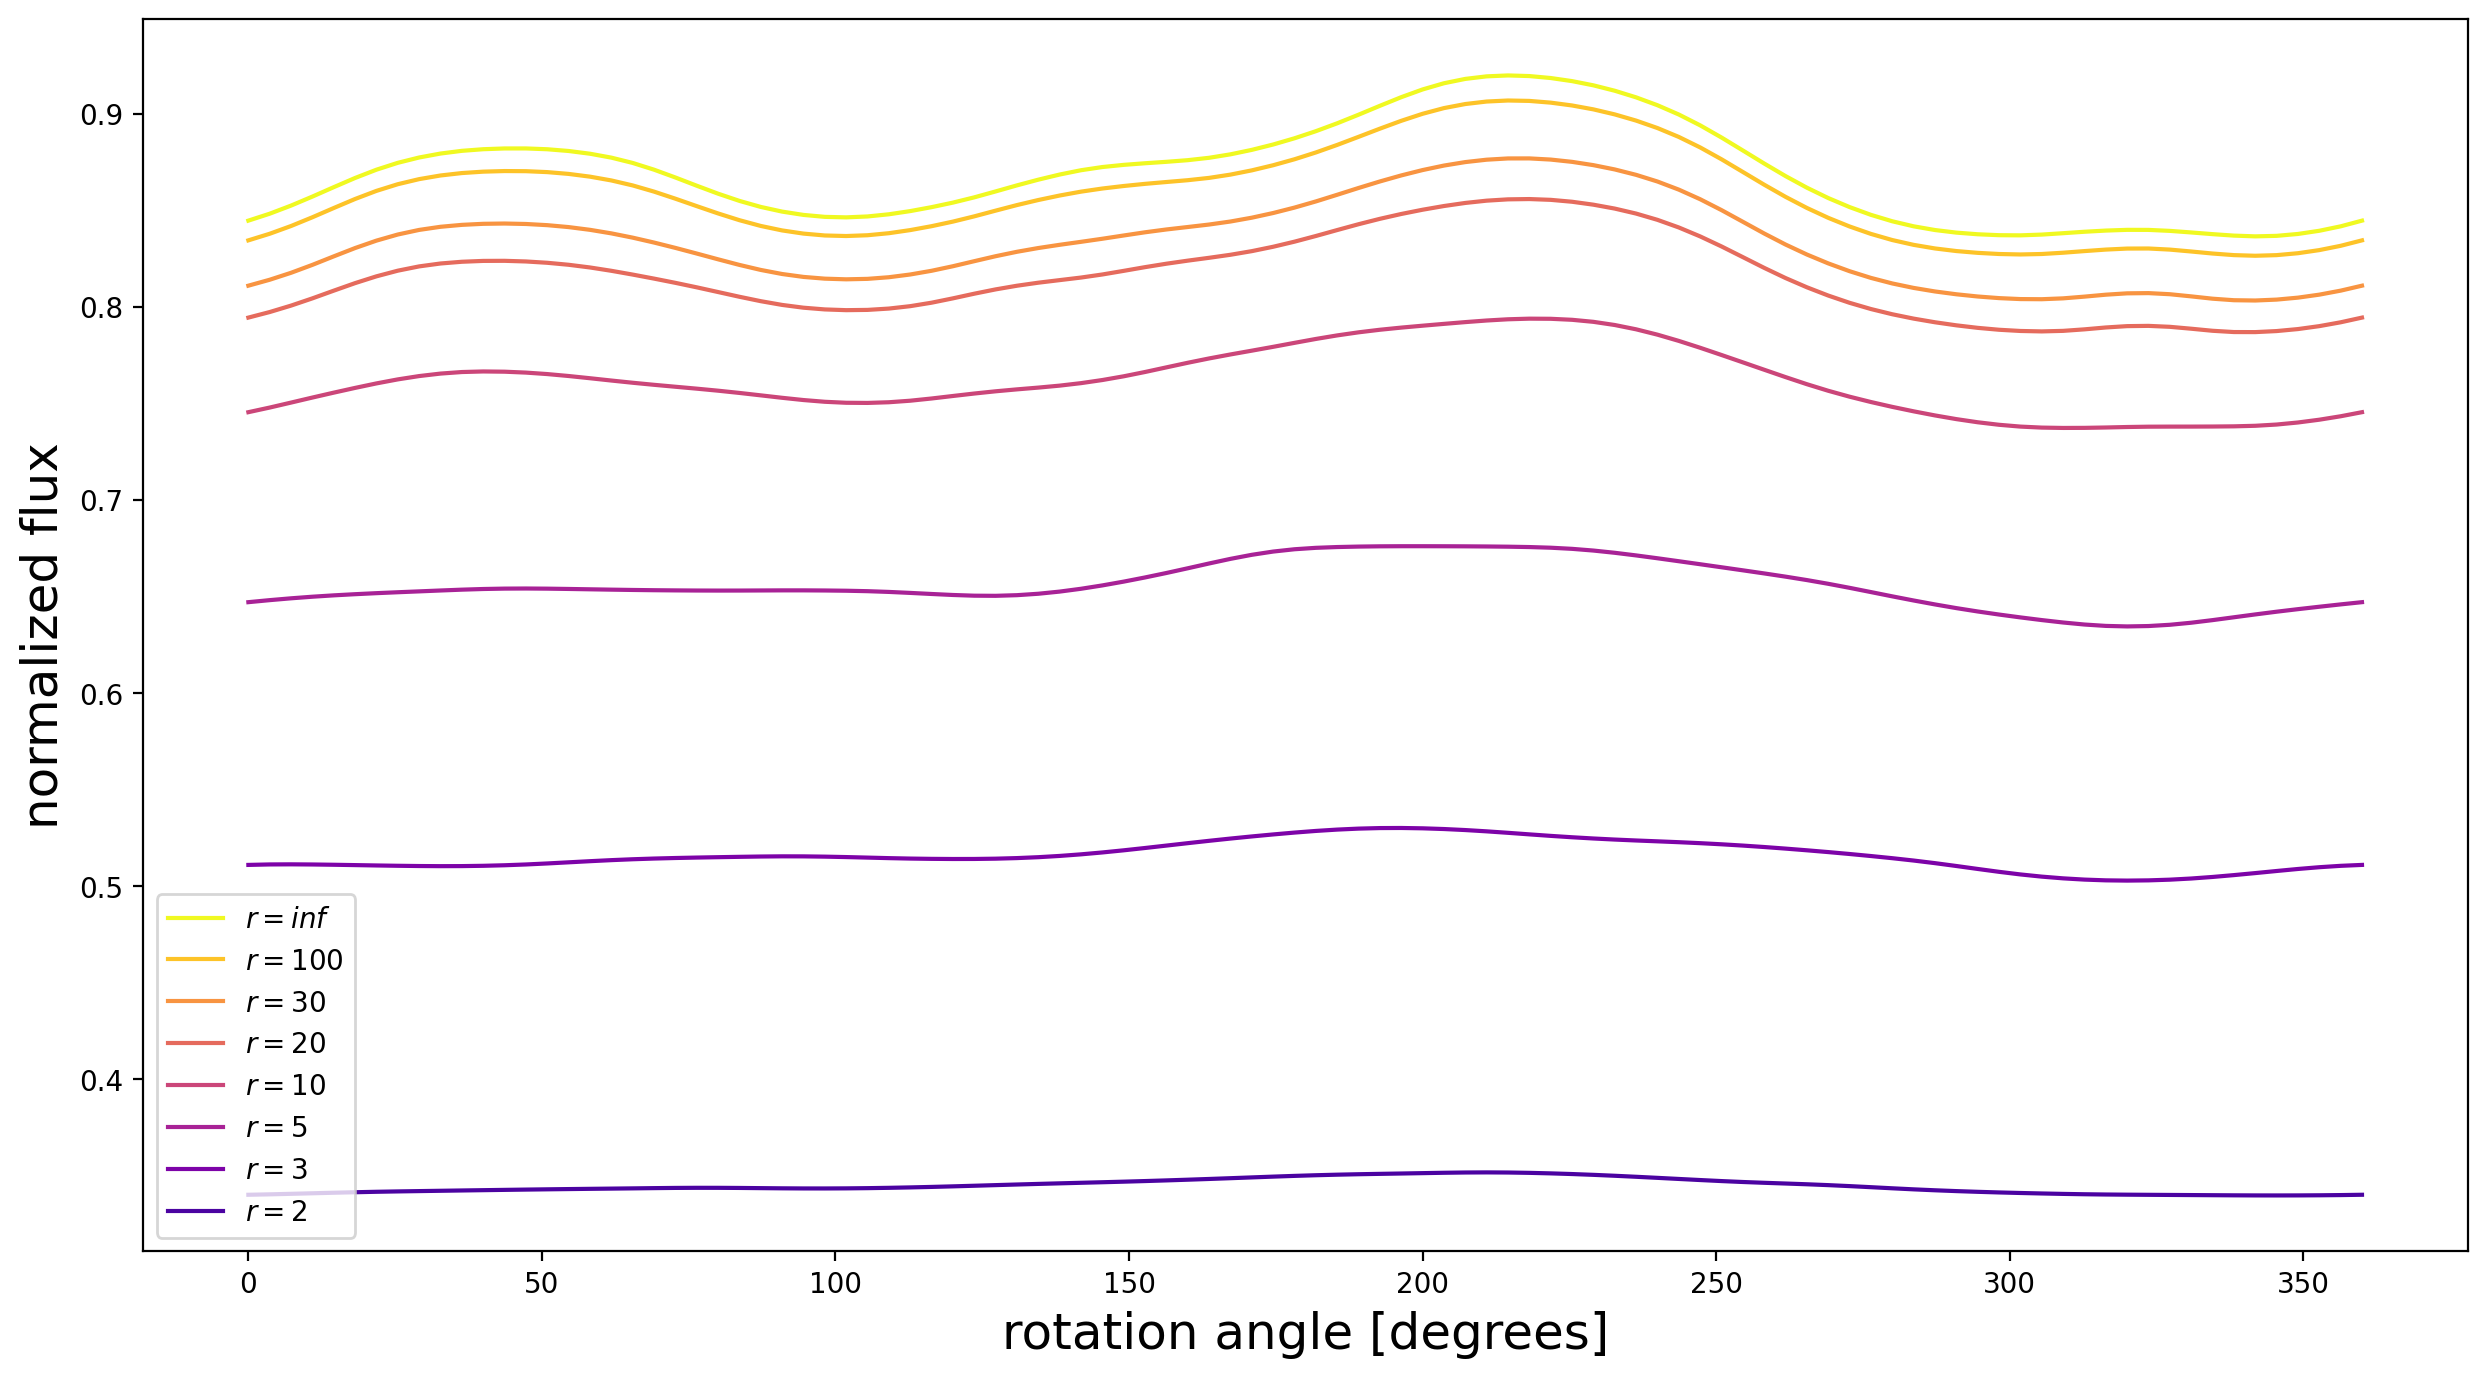

In [54]:
fig, ax = plt.subplots(1, figsize=(15, 8))
cmap = plt.get_cmap("plasma_r")
for n, rs in enumerate([np.inf, 100, 30, 20, 10, 5, 3, 2]):
    plt.plot(theta, flux(theta, map.y, lmax=30, rs=rs,vrot=0.3), label=f"$r={rs}$", color=cmap(n/8))
plt.xlabel("rotation angle [degrees]", fontsize=18)
plt.ylabel("normalized flux", fontsize=18)
plt.legend()

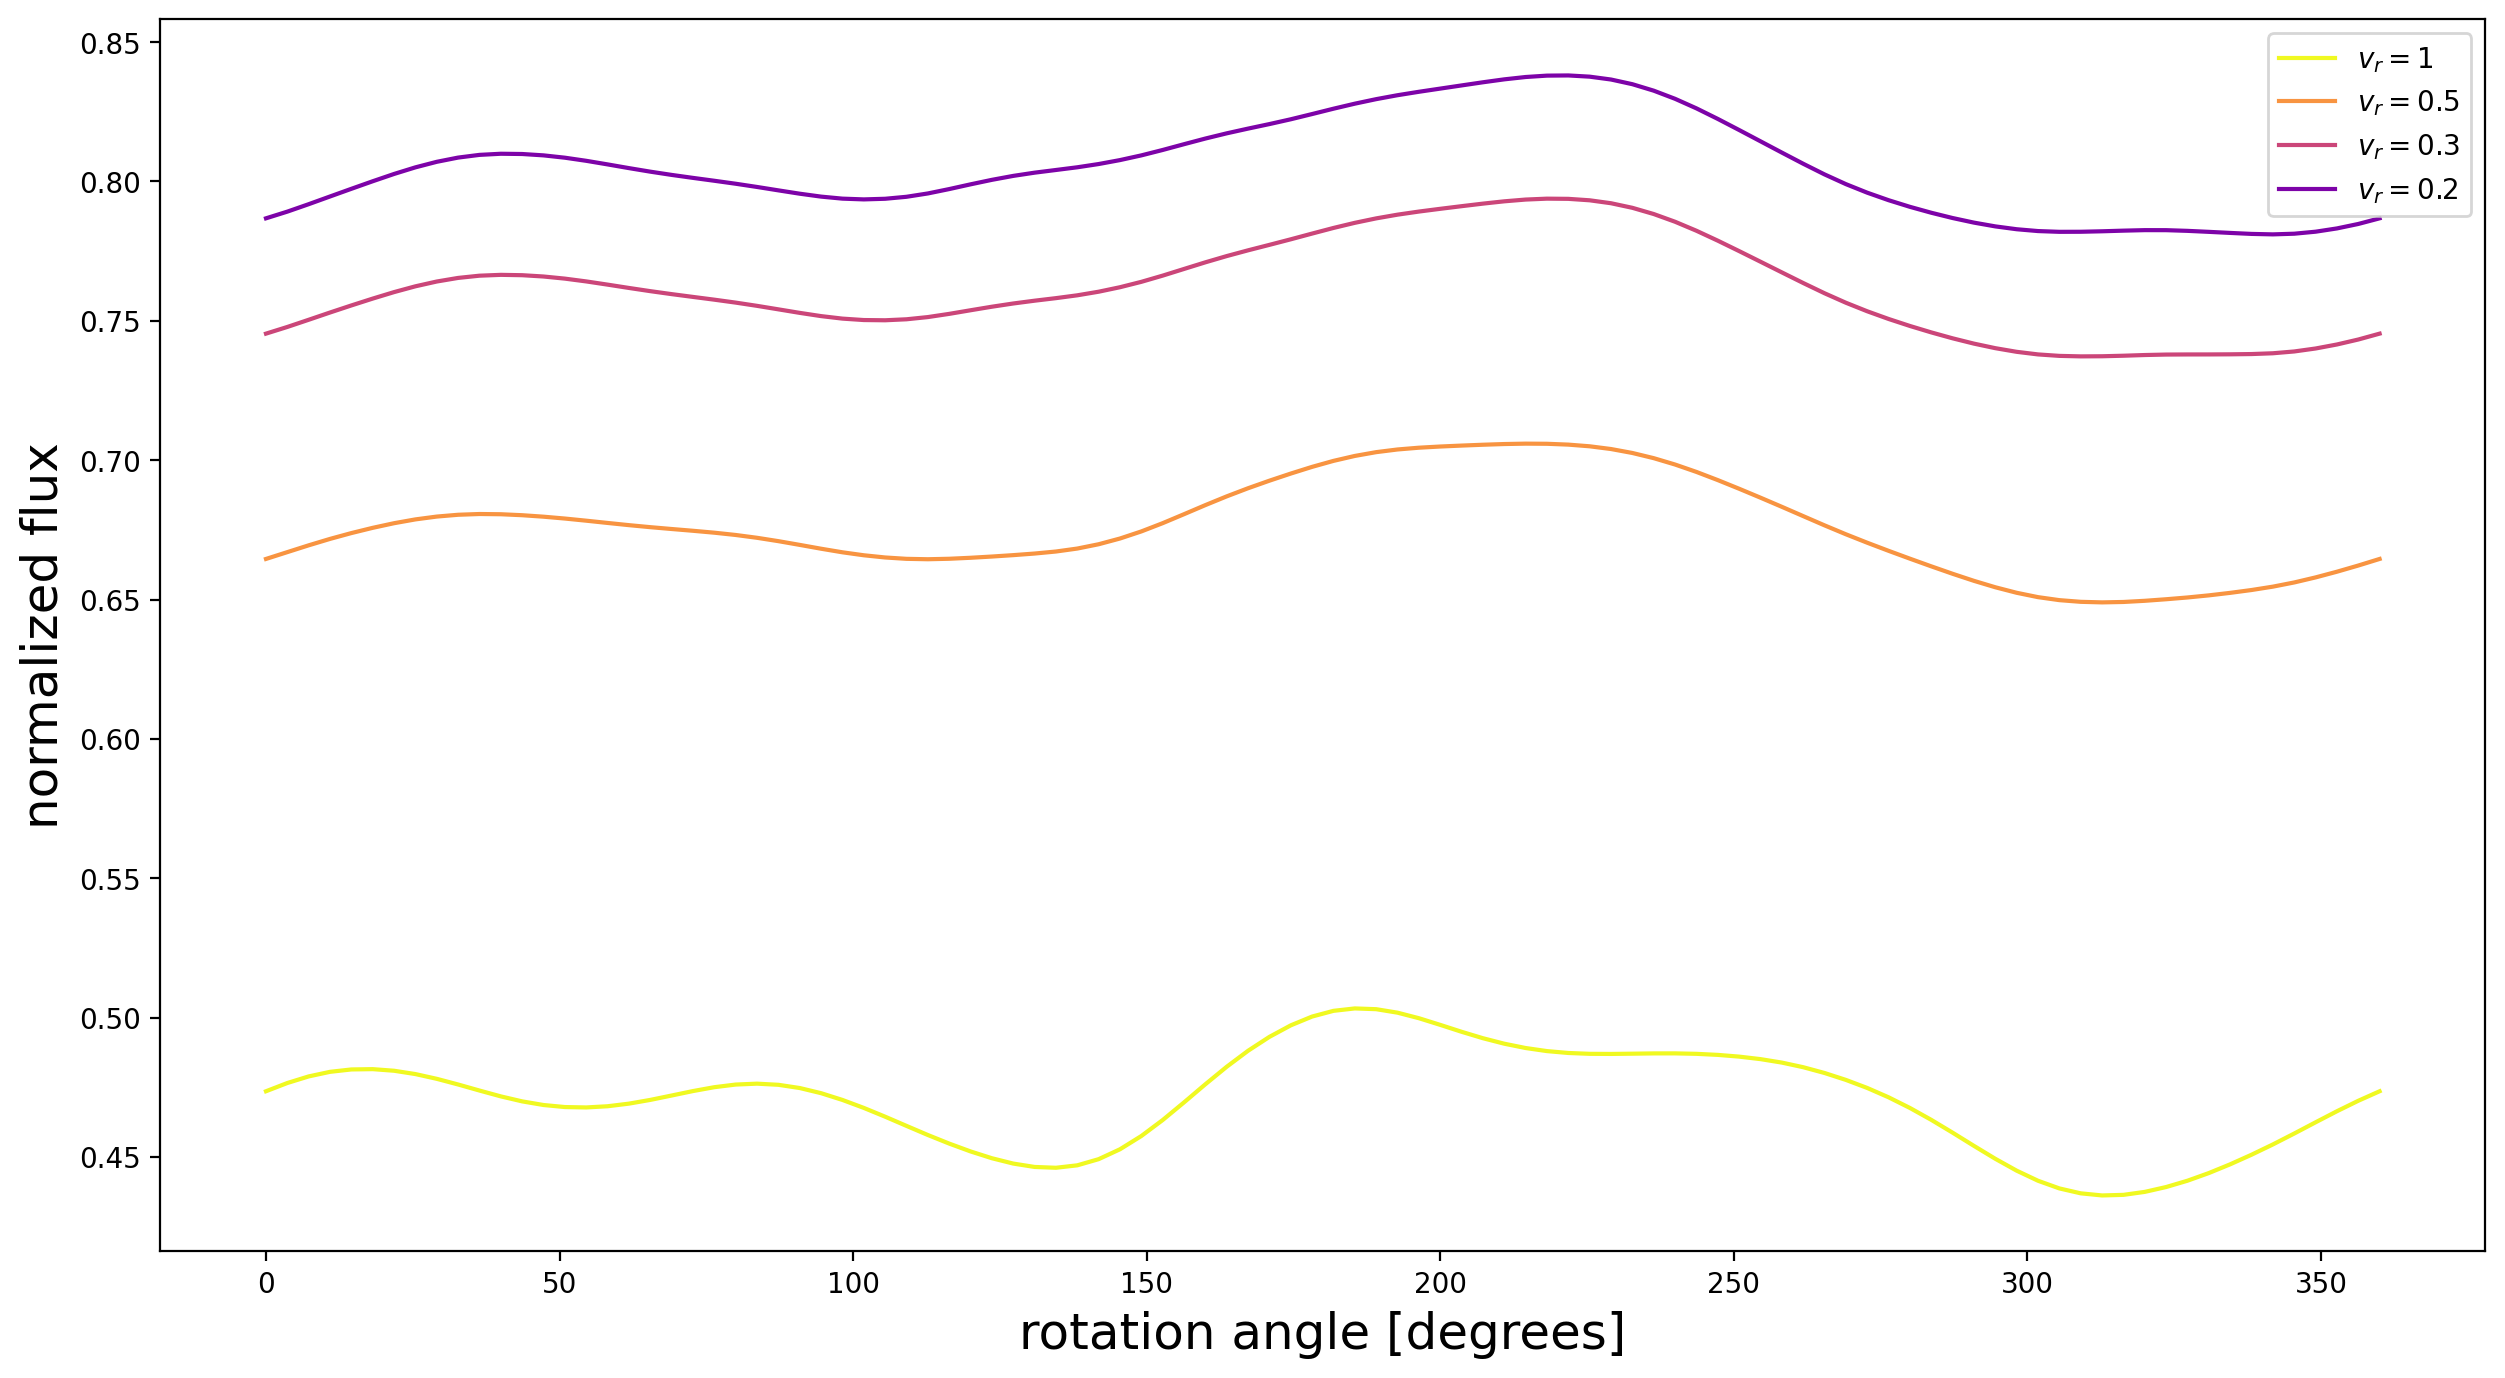

In [58]:
fig, ax = plt.subplots(1, figsize=(15, 8))
cmap = plt.get_cmap("plasma_r")
for n, vrot in enumerate([1, 0.5, 0.3, 0.2]):
    plt.plot(theta, flux(theta, map.y, lmax=30, rs=10, vrot=vrot), label=f"$v_r={vrot}$", color=cmap(n/4))
plt.xlabel("rotation angle [degrees]", fontsize=18)
plt.ylabel("normalized flux", fontsize=18)
plt.legend()

In [16]:
rs = 2
nx = 300

x, y = np.linspace(-1, 1, nx), np.linspace(-1, 1, nx)
x, y = np.meshgrid(x, y)
x = x.flatten()
y = y.flatten()
lat, lon = transform(x, y, rs=rs)
I = np.zeros((len(theta), nx, nx))
for n in range(len(theta)):
    I[n] = map.intensity(lat=lat, lon=lon - theta[n]).reshape(nx, nx)

In [17]:
map.show(theta=theta, image=I)

RuntimeError: Requested MovieWriter (ffmpeg) not available

To find the time delay between the photon falling onto the neutron star and the observer watching, you will need to use the Shapiro time delay formula.

The Shapiro time delay formula gives the time delay experienced by a photon as it travels through a gravitational field. It can be written as:

$$
\Delta t = 2 \int_0^1 \frac{dr}{1 - \frac{2GM}{c^2 r}} \sqrt{1 - \frac{b^2}{r^2}}
$$

where $M$ is the mass of the neutron star, $c$ is the speed of light, $b$ is the impact parameter (i.e., the minimum distance between the photon and the center of the neutron star), and $G$ is the gravitational constant.

The integral in this formula is taken along the path of the photon, from the point where it is emitted to the point where it is observed. The time delay is then given by the difference between the time it takes the photon to travel this path in the presence of the gravitational field, and the time it would take to travel the same path in the absence of the gravitational field.